# SurPyval

This notbook shows some of the uses of the surpyval package.

First step is non parametric survival analysis

In [1]:
import nonparametric as nonp
import WeibullScale
import numpy as np

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

For these anlyses, we will go back to the beinging and use Weibull's original yield strength of bofors steel data. This is the yield strength, measured in (oddly) 1.275 kg/mm^2 and the number of observations.

In [3]:
x = np.array([32, 33, 34, 35, 36, 37, 38, 39, 40, 42])
n = np.array([10, 33, 81, 161, 224, 289, 336, 369, 383, 389])

# Mr Weibull's measurements are cumulative, so let's calculate the obervations at each point.
n = np.concatenate([[n[0]], np.diff(n)])

Using this data we can esimtate the reliability, that is, the probability that a sample of steel will survive up to a given applied stress. So what does that mean?

We can find when the steel will break. This is particularly useful when we know the application.

For this example, lets say that the maximum tensile stress our design will see during use is 33 units. Lets try and estimate the proportion that will fail during operation.

For this we can use the [Nelson-Aalen](https://en.wikipedia.org/wiki/Nelson%E2%80%93Aalen_estimator) estimator of the hazard rate, then convert it to the reliability. This is all done with one easy call.

In [4]:
stress, r, d, R = nonp.nelson_aalen(x, n=n)

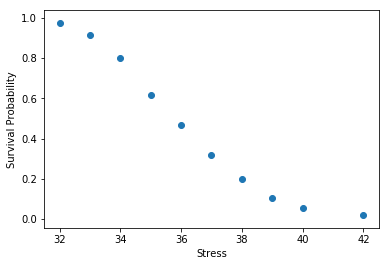

In [5]:
plt.ylabel('Survival Probability')
plt.xlabel('Stress')
ax = plt.scatter(stress, R)

So what purpose is this?

We can use this result to estimate 

In [6]:
bofors_steel = nonp.NonParametric.fit(x, n=n)

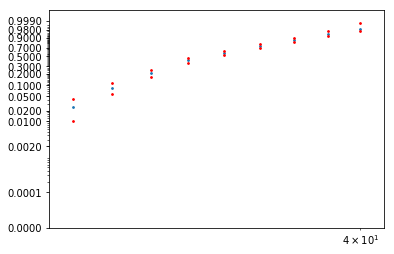

In [13]:
plt.yscale('weibull')
plt.xscale('log')
size = 3
plt.scatter(bofors_steel.x, 1 - bofors_steel.R, s=size)
plt.scatter(bofors_steel.x, 1 - bofors_steel.cb_u, color='r', s=size)
plt.scatter(bofors_steel.x, 1 - bofors_steel.cb_l, color='r', s=size)